# Model Training Iteration 1
Model training here contains:
- Dataset only sourced from the internet 
- Class imbalance solved via down sampling without replacement 
- Simple CNN architecture  

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Constants

In [5]:
TARGET_WORD='marvin'
SEED= 324234

## Functions

In [13]:
def down_sample_dataset(X,Y,target_class,seed):
    np.random.seed(seed)
    positive_index=np.where(Y==target_class)[0]
    num_positive=len(positive_index)
    Y_with_positive=Y[positive_index]
    X_with_positive=X[positive_index]

    unique_class=np.unique(Y)
    unique_class_sub_positive=np.delete(unique_class,target_class)

    num_remaining_class=unique_class_sub_positive.shape[0]
    num_sample_per_remaining_class=int(len(positive_index)/num_remaining_class)

    balanced_samples=num_positive+num_remaining_class*num_sample_per_remaining_class
    X_balanced_shape=np.concatenate([[balanced_samples],X.shape[1:]])
    Y_balanced=np.empty((balanced_samples,),dtype=int)
    X_balanced=np.empty(X_balanced_shape,dtype=object)
    Y_balanced[:num_positive]=Y_with_positive
    X_balanced[:num_positive]=X_with_positive


    for i,remain_class in enumerate(unique_class_sub_positive):
        class_index=np.where(Y==remain_class)[0]
        sample_class_index=np.random.choice(class_index,size=num_sample_per_remaining_class,replace=False)
        start_index=num_positive+i*num_sample_per_remaining_class
        stop_index=num_positive+(i+1)*num_sample_per_remaining_class
        X_balanced[start_index:stop_index]=X[sample_class_index]
        Y_balanced[start_index:stop_index]=Y[sample_class_index]

    def binarizer(array_element,label):
        if array_element==label:
            return 1
        else:
            return 0

    v_binarizer=np.vectorize(binarizer)
    Y_balanced=v_binarizer(Y_balanced,target_class)

    return X_balanced,Y_balanced

    


## Processing data 

In [8]:
import os

SPEECH_DATA='/src/audio_data'

def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
target_class=words.index(TARGET_WORD)

In [9]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('/src/training_spectrogram.npz')
validation_spectrogram = np.load('/src/validation_spectrogram.npz')
test_spectrogram = np.load('/src/test_spectrogram.npz')

In [10]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [11]:
#balancing the dataset
X_train_bal,Y_train_bal=down_sample_dataset(X_train,Y_train,target_class,SEED)
X_validate_bal,Y_validate_bal=down_sample_dataset(X_validate,Y_validate,target_class,SEED)
X_test_bal,Y_test_bal=down_sample_dataset(X_test,Y_test,target_class,SEED)

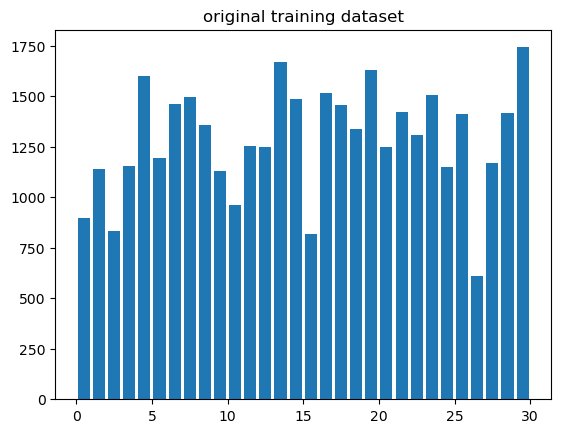

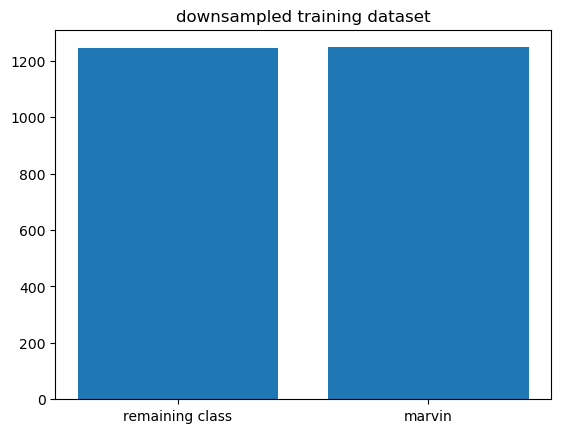

In [12]:
plt.hist(Y_train,bins=range(0,len(np.unique(Y_train))+1),rwidth=0.8)
plt.title('original training dataset')
plt.show()

plt.hist(Y_train_bal,bins=range(0,len(np.unique(Y_train_bal))+1),rwidth=0.8)
plt.xticks([0.5,1.5],['remaining class','marvin'])
plt.title('downsampled training dataset')
plt.show()

## To Do 
- Explore the training data set 
- Train with simple CNN